# A Demo of IML-ViT

This notebook provides a example of our training & inference pipeline of how to apply IML-ViT to image manipulation localization tasks.

### Requirements
You should install the requirements in `./requirements.txt` and manually install following requirements before run this note book：
- PyTorch
- OpenCV (cv2)

### Load Dataset
- We defined two types of Dataset class
  - `json_dataset`, which get input image and correspoding groundtruth from a json file with protocol like this:
    ```
    [
        [
          "/Dataset/CASIAv1/Tp/image1.jpg",
          "/Dataset/CASIAv2/Gt/image1.jpg"
        ],
        [
          "/Dataset/CASIAv1/Tp/image2.jpg",
          "Negative"
        ],
        ......
    ]
    ```
    where "Negative" represent a totally black groundtruth that don't needs a path(all authentic)
  - `mani_dataset` which loads image and groundtruth pairs automaticlly from a directory having sub-directories named as `Tp` (for input images) and `Gt` |(for groundtruths). This class will use sorted `os.listdir()` function to generate the pairs. 
- These datasets will do **zero-padding** automatically. Common augumentation method like ImageNet normalization will also be added.
- Both datasets can generate `edge_mask` when specify the `edge_width` parameter. Then, this dataset will return 3 objects (image, GT, edge mask) while only 2 objects when `edge_width=None`.
- For inference, returing the actual shape of the original image is crucial. You can set `if_return_shape=True` to get this value. 

In [1]:
# Pre-import and set for a clear ploting
from main_train import Args
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 60
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (24, 6)
from utils.datasets import mani_dataset # special Dataset class

/media/chirag/Chirag/Major project/IML-ViT/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/chirag/Chirag/Major project/IML-ViT/.venv/lib/python3.9/site-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing from timm.optim.optim_factory is deprecated, please import via timm.optim
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.optim", FutureWarning)


2.7.0+cu126
Current Torch version: 2.7


/media/chirag/Chirag/Major project/IML-ViT/.venv/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# here we use mani dataset as example
input_dir = "Demo"
dataset = mani_dataset(
    path = input_dir,
    edge_width=7, # specify the edge mask, other wise only return 2 objects
    if_return_shape=True
)
print(dataset)
print(f":ength of this dataset: {len(dataset)}")

:ength of this dataset: 2


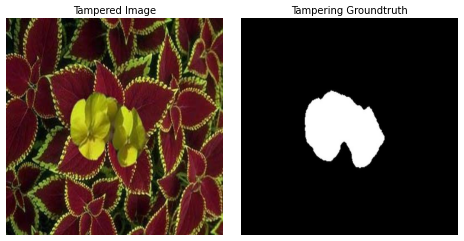

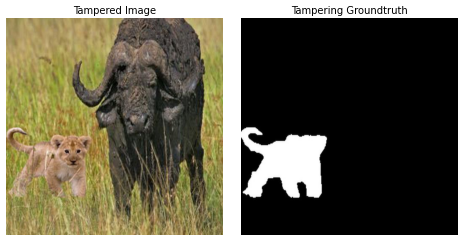

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to convert image to PNG format if it's not already in PNG
def convert_to_png(img_path):
    img = Image.open(img_path)
    # Convert to PNG if it's not already a PNG
    if img.format != 'PNG':
        # Save as PNG
        png_path = os.path.splitext(img_path)[0] + '.png'
        img.save(png_path, 'PNG')
        return png_path
    return img_path

# Show only 4 examples
for img_path, gt_path in list(zip(dataset.tp_path, dataset.gt_path))[:2]:
    # Convert images to PNG if needed
    img_path = convert_to_png(img_path)
    gt_path = convert_to_png(gt_path)
    
    # Load the images
    img = plt.imread(img_path)
    gt = plt.imread(gt_path)

    # Plot the images
    plt.figure(figsize=(8, 4))  # Optional: improve layout
    plt.subplot(1, 2, 1)
    plt.title("Tampered Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Tampering Groundtruth")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].


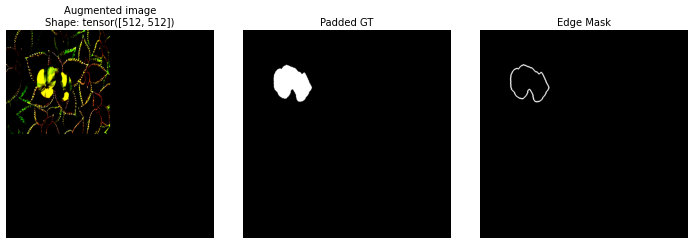

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2710083].


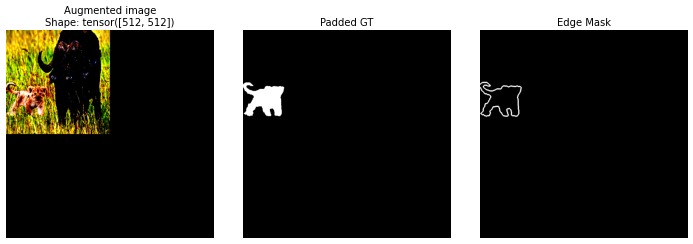

In [4]:
# Visualize after build-in transform (zero-padding and augmentations)
for idx, (img, gt, edge_mask, shape) in enumerate(dataset):
    if idx >= 2:
        break
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    img = img.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(img)
    plt.title(f"Augmented image\nShape: {shape}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    gt = gt.permute(1, 2, 0)
    plt.imshow(gt, cmap='gray')
    plt.title("Padded GT")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    edge_mask = edge_mask.permute(1, 2, 0)
    plt.imshow(edge_mask, cmap='gray')
    plt.title("Edge Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


### Download the weights and init the IML-ViT model
You should download the pretrained weights from [Google Drive](https://drive.google.com/drive/folders/1Ztyiy2cKJVmyusYMUlwuyPecBefTJCPT?usp=sharing) or [Baidu NetDisk](https://pan.baidu.com/s/1IqyJdFLUo9bXEhvqOJkvvg?pwd=2k0o) and place it as `./checkpoints/iml-vit_checkpoint.pth`


**IMPORTANT NOTE**: The checkpoint your trained which obtained from `main_train.py` is organized in dictionary format, including many parameters such as model, optimizer, and so on. This leads to a size checkpoint over 1GB. Its format is roughly as follows:

```json
{
    "model": <state_dict of model>,
    "optimizer": <state_dict of model>,
    ......
}
```

However, to save space, demo.ipynb by default **only reads the model parameters**. The provided pretrained weights from online drive are also following this format. In other words, it expects to read a PyTorch checkpoint file that **only contains** an object of <state_dict of model>. 


You can strip the model `state_dict` from your customed trained checkpoint with following script:
```python
import torch
model = torch.load("/mnt/data0/xiaochen/workspace/IML-VIT/output_dir/checkpoint-150.pth")
output = model['model']
torch.save(output, "checkpoint-150.pth")
```


In [5]:
import torch
from iml_vit_model import iml_vit_model

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # if out of memory, then uncommenting this line

print("Device:", device)

ckpt_path = "checkpoints/iml-vit_checkpoint.pth"
model = iml_vit_model()

try:
    # try load offical released checkpoint 
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint, strict=True)
    print("Official pretrained checkpoint loaded successfully.")
except Exception as e:
    print(f"Failed to load official checkpoint : {e}, try load 'torch.load(ckpt_path)['model']' instead.")
    try:
        # try load 'model' key from checkpoint
        checkpoint = torch.load(ckpt_path)['model']
        model.load_state_dict(checkpoint, strict=True)
        print("Custom checkpoint loaded successfully.")
    except Exception as e:
        print(f"Failed to load custom checkpoint: {e}")

# Move model to device
model = model.to(device)


Device: cuda
Official pretrained checkpoint loaded successfully.


### Inference
This process require your GPU has at least 6GB of memory.

shape: tensor([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].


Predict Loss:0.03196408532839523, including edge loss: 0.026232948574307358


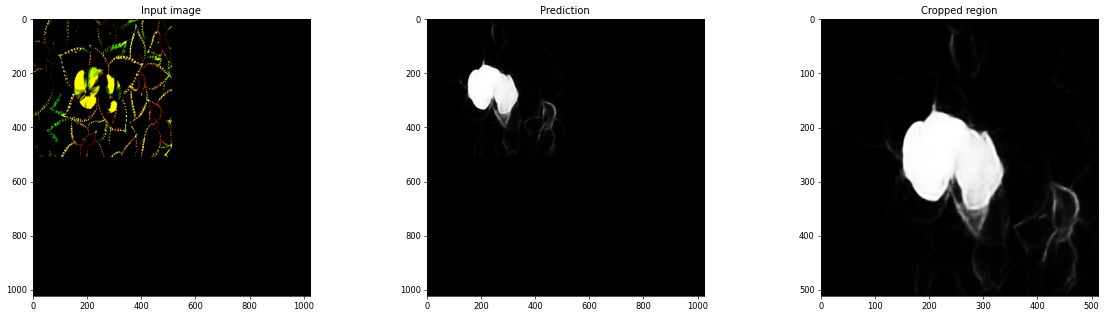

shape: tensor([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2710083].


Predict Loss:0.03355181087012525, including edge loss: 0.031411122088378374


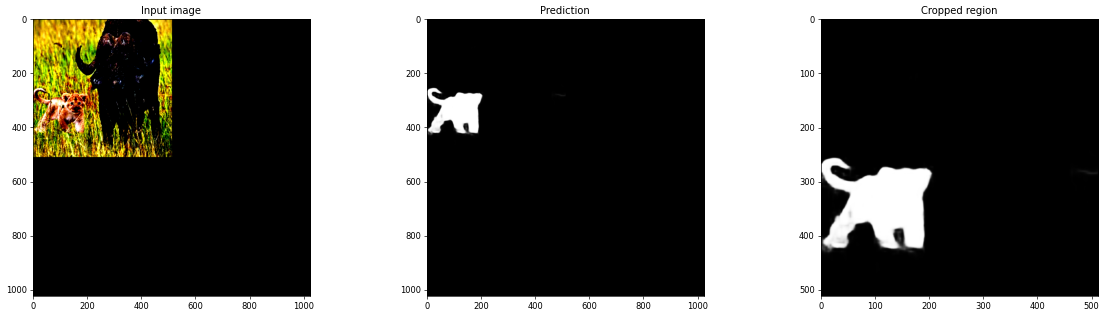

Done!


In [6]:
results = []
model.eval()
with torch.no_grad():
    for idx ,(img, gt, edge_mask, shape) in enumerate(dataset):    # Inference don't need edge mask.
        if idx >= 2:
            break
        img, gt, edge_mask = img.to(device), gt.to(device), edge_mask.to(device)
        # Since no Dataloader, manually create a Batch with size==1
        img = img.unsqueeze(0) # CHW -> 1CHW
        gt = gt.unsqueeze(0)
        edge_mask = edge_mask.unsqueeze(0)
        print("shape:", shape)
        # inference
        predict_loss, mask_pred, edge_loss = model(img, gt, edge_mask)
        print(f"Predict Loss:{predict_loss}, including edge loss: {edge_loss}")
        output = mask_pred
        
        # visualize
        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
        plt.subplot(1, 3, 2)
        plt.title("Prediction")
        plt.imshow(output.cpu().numpy()[0][0], cmap='gray')


        # Cut the origin area from padded image
        output = output[0, :, 0:shape[0], 0:shape[1]].permute(1, 2, 0).cpu().numpy()
        results.append(output)
        plt.subplot(1, 3, 3)
        plt.title("Cropped region")
        plt.imshow(output, cmap='gray')
        plt.show()
print("Done!")

### Thresholding & comparison

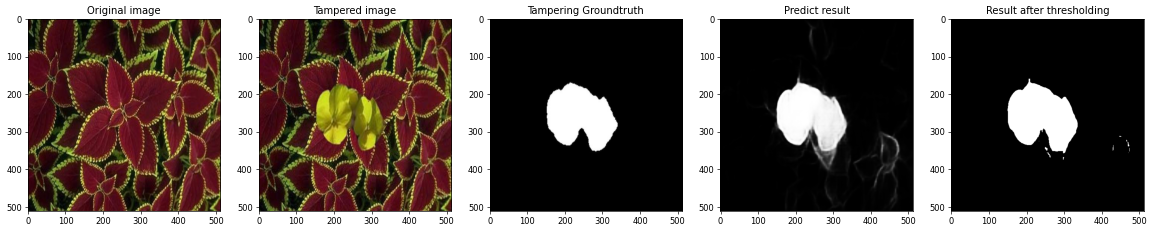

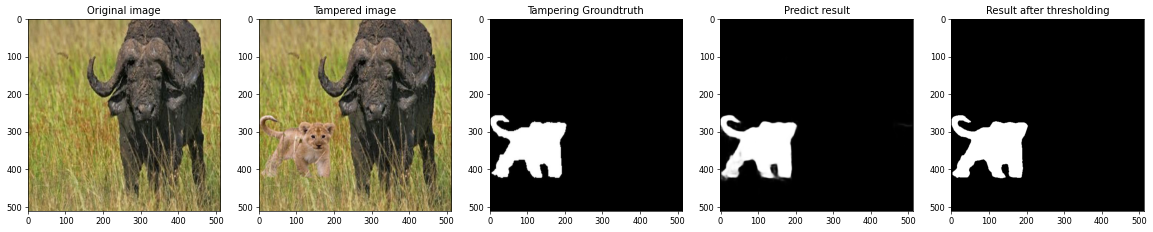

In [13]:
# Visualize the results:
import os

def get_image_files(directory):
    supported_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff")
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(supported_extensions)]

# Example usage
image_dir = "Demo/Au"
image_list = sorted(get_image_files(image_dir), reverse=True)

for img, tp_img, gt, res in list(zip(image_list, dataset.tp_path, dataset.gt_path, results))[:3]:
    img = plt.imread(img)
    tp_img = plt.imread(tp_img)
    gt = plt.imread(gt)
    plt.subplot(1, 5, 1)
    plt.title("Original image")
    plt.imshow(img)
    plt.subplot(1, 5, 2)
    plt.title("Tampered image")
    plt.imshow(tp_img)
    plt.subplot(1, 5, 3)
    plt.title("Tampering Groundtruth")
    plt.imshow(gt, cmap="gray")
    plt.subplot(1, 5, 4)
    plt.title("Predict result")
    plt.imshow(res, cmap="gray")
    plt.subplot(1, 5, 5)
    plt.title("Result after thresholding")
    plt.imshow(res > 0.5, cmap="gray")
    plt.show()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


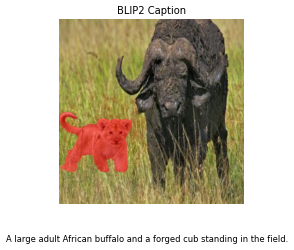

In [14]:
from blip2_captioner import overlay_mask_on_image, captioner

overlay_image = overlay_mask_on_image(img_path, gt_path)

caption = captioner(overlay_image)

# Generate overlay + caption

# Display the overlay image and caption


plt.figure(figsize=(6, 4))
plt.imshow(overlay_image)
plt.title("BLIP2 Caption")
plt.axis("off")
plt.figtext(0.5, -0.05, caption, wrap=True, ha='center', fontsize=10)
plt.show()



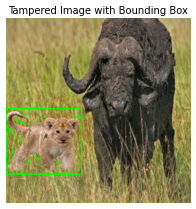

In [9]:
import cv2
def draw_bounding_boxes(mask_path, image_path=None):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path) if image_path else cv2.cvtColor(mask.copy(), cv2.COLOR_GRAY2BGR)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw boxes on the original image
boxed_image = draw_bounding_boxes(gt_path, img_path)

plt.figure(figsize=(6, 4))
plt.imshow(boxed_image)
plt.title("Tampered Image with Bounding Box")
plt.axis("off")
plt.show()
